# Projeto final de processamento de imagens
## Relatório parcial

Alunos:
- Victor Akihito Kamada Tomita - 10692082
- Lucas Xavier Ebling Pereira - 10692183
- Luís Felipe Ribeiro Chaves - 10801221
- Henrique Tadashi Tarzia - 10692210

### Explicação geral do que é feito neste notebook

O objetivo deste código é extrair áreas de floresta de imagens de satélite para que seja possível comparar a mudança da vegetação com o tempo e detectar regiões de desmantamento ou reflorestação.

As operações realizadas para alcançar tal objetivo são:
1. A imagem alvo é lida no modelo de cor RGB
2. A imagem alvo é convertida para o modelo HLS
3. A imagem é binarizada seguindo o seguinte critério:
    - O valor 1 é assinalado para todas regiões com hue entre 110 e 200 (considerando um hue no intervalo 0-360), que representa a cor verde, e luminance inferior a cerca 25%, que representa cores escuras. Ou seja, é atribuído o valor 1 para todos os pixels verde-escuro
    - O valor 0 é assinalado aos demais pixels
4. É realizado uma operação de opening para reduzir áreas isoladas que são verde-escuras.

Imports das bibliotecas utilizadas para realização do filtro

In [49]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label

Leitura da imagem de input. Observe que a biblioteca cv2 realiza a leitura da imagem no modelo BGR. Para evitar confusões, estamos convertendo as imagens para RGB após a leitura

In [50]:
img_path = 'input2.png'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

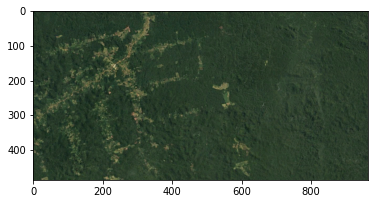

In [51]:
plt.imshow(img)

Aplicamos um filtro gaussiano 5x5 de desvio padrão .5 para embaçar levemente a imagem para suprimir pequenos ruídos.

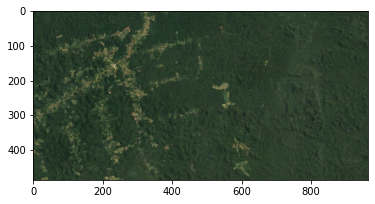

In [52]:
blur_img = cv2.GaussianBlur(img, (5, 5), .5)
plt.imshow(blur_img)

Convertemos a imagem de RGB para HSL

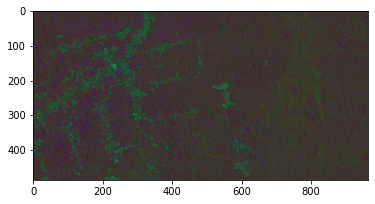

In [53]:
hls_img = cv2.cvtColor(blur_img, cv2.COLOR_RGB2HLS)
plt.imshow(hls_img)

Na biblioteca cv2, os valores do HSL possuem os seguintes ranges:

- Hue: [0-179] (360//2 valores)
- Luminance: [0-255]
- Saturation: [0-255]

Dessa forma, para binarizar o mapa em regiões verde-escuras e regiões de outras cores, basta utilizar a função inRange do cv2, estabelecendo os limites da cor desejada. 

No caso, a cor verde é representada por um Hue de 54 a 100 e uma tonalidade escura é representada por uma Luminance baixa (escolhemos o valor 60). 

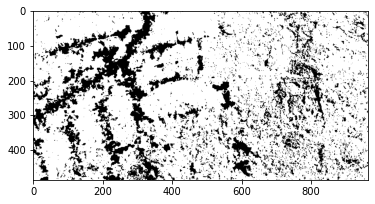

In [54]:
# https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv

GREEN_MIN = np.array([54, 0, 0],np.uint8) # 0-360 110-200 0-179 54-100
GREEN_MAX = np.array([100, 60, 255],np.uint8)

green_img = cv2.inRange(hls_img, GREEN_MIN, GREEN_MAX)
plt.imshow(green_img, cmap='gray')

Por fim, com o intuito de remover alguns ruídos de cores verde-escura isolada ou de cores não verde-escuras dentro de regiões florestais (na imagem binarizada isso equivale a pontos brancos isolados ou pontos pretos em regiões brancas), iremos aplicar uma operação de closing, removendo pequenos pontos brancos em regiões pretas.

Com o intuito de testar, testamos com 2 discos de tamanhos diferentes combinados. Chegamos a conclusão de que a utilização do disk2 foi a melhor.

In [55]:
def display_comparison(imgs, names):
    fig, axs = plt.subplots(1, len(names), figsize=(20, 6))
    for ax, method in zip(axs, names):
        ax.imshow(imgs[method], cmap='gray')
        ax.set_title(method.capitalize())
    plt.show()

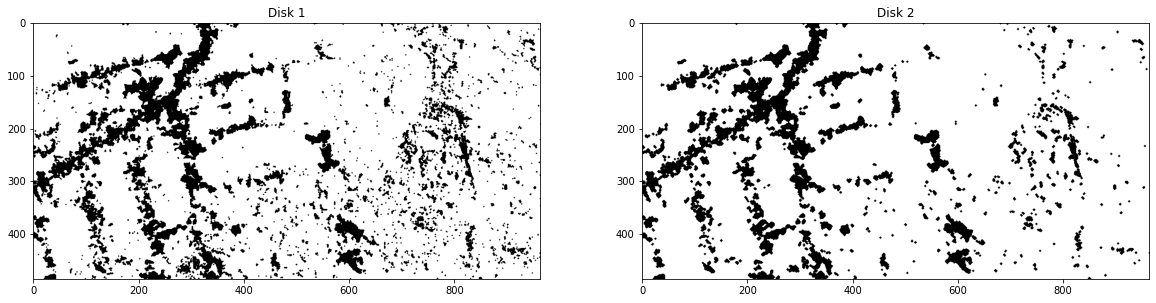

In [56]:
disk1 = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
], np.uint8)

disk2 = np.array([
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0]
], np.uint8)

disk1_img = green_img.copy()
disk2_img = green_img.copy()

dilated_img1 = cv2.dilate(disk1_img, disk1)
eroded_img1 = cv2.erode(dilated_img1, disk1)
disk1_img = eroded_img1

dilated_img2 = cv2.dilate(disk2_img, disk2)
eroded_img2 = cv2.erode(dilated_img2, disk2)
disk2_img = eroded_img2

imgs = {'Disk 1': disk1_img, 'Disk 2': disk2_img} 
display_comparison(imgs, ['Disk 1', 'Disk 2'])

Para a próxima, pretendemos segmentar melhor áreas florestais de áreas de plantio verde-escuras. Pretendemos realizar isso analisando a variância das regiões (Áreas com grande variância costumam ser florestas devido a diferença entre texturas de folhagens e plantações). Também realizaremos tentativas de melhoria da remoção de ruídos.

Também pretendemos analisar outros técnicas que realizem essa tarefa para efeito de comparação.

Por fim, como objetivo final deste trabalho, pretendemos atribuir uma nota de vegetação para a imagem de satelite que poderá ser comparada temporalmente.

Para o desenvolvimento desse código foi utilizado esse tutorial https://clouard.users.greyc.fr/Pantheon/experiments/forestarea-extraction/index-en.html 

## Entrega final

Para esta entrega final, tentaremos desenvolver o seguinte:


*   Filtro por regiões com alta variância (idealmente por serem regiões com folhagem)
* Aplicação de técnicas de segmentação baseadas em histograma 
*   Remoção de regiões com áreas menores que um certo threshold para remoção de ruído



### Filtro de variância

A ideia dessa etapa é filtrar áreas com variância alta e depois fazer uma interseção do resultado com o que foi obtido no final da etapa 2. Era esperado um bom resultado pelo fato de áreas desmatadas serem mais homogêneas que áreas florestais devido à folhagem das árvores.

Entretanto, testamos diversos parâmetros e não conseguimos melhoria significante com esse filtro e, por isso, desistimos dele.

Testamos com filtro de variância de kernel 3, 5, 7 e 9 e vários thresholds de variância diferentes (tanto valores fixos quanto valores baseados em quantis).

In [57]:
def generate_var_img(img, half_kernel_shape):
    var_img = np.zeros((img.shape[0], img.shape[1]))

    for line in range(half_kernel_shape, img.shape[0] - half_kernel_shape):
        for col in range(half_kernel_shape, img.shape[1] - half_kernel_shape): 
            range_img = img[line - half_kernel_shape : line  + half_kernel_shape + 1, col - half_kernel_shape : col + half_kernel_shape + 1]
            var_img[line, col] = np.var(range_img)
            
    return var_img

In [58]:
def remove_outliers(array):
    q1, q3 = np.quantile(array, [0.25, 0.75])
    qr = q3 - q1
    
    min = q1 - 1.5 * qr
    max = q1 + 1.5 * qr
    
    final = np.clip(array, min, max)

    return final

In [59]:
def normalize(array, max=255):
    maxi, mini = array.max(), array.min()
    diff = maxi - mini
    
    if diff == 0:
        diff = 1
    
    norm = ((array - mini) / diff)

    return norm * max

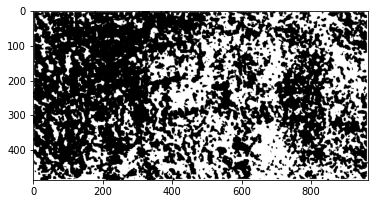

In [60]:
var_img = generate_var_img(cv2.cvtColor(img, cv2.COLOR_RGB2HLS), 3)
var_img_no_outliers = remove_outliers(var_img)
var_img_norm = normalize(var_img)

threshold = np.quantile(var_img_norm, [0.4])

var_img_norm_final = np.zeros(var_img_norm.shape)
var_img_norm_final[var_img_norm > threshold] = 255
var_img_norm_final[var_img_norm <= threshold] = 0

aux = var_img_norm_final.copy()
aux[var_img_norm_final == 255] = 0
aux[var_img_norm_final == 0] = 255

var_img_norm_final = aux

eroded_img3 = cv2.erode(var_img_norm_final, disk2)
dilated_img3 = cv2.dilate(eroded_img3, disk2)

final_and = np.logical_and(var_img_norm_final, disk2_img)
img_final = np.zeros(final_and.shape)
img_final[final_and] = 255

_ = plt.imshow(img_final, cmap='gray')

### Técnicas de segmentação

Além das tentativas de detecção das regiões florestais a partir das tonalidades de verde, realizaram-se experimentos utilizando como entrada a imagem em escala de cinza, obtida por meio da técnica de luminância. Para tal, empregamos a segmentação por um threshold fixo, correspondente ao valor médio da tonalidade, e o Método de Otsu, que tem por objetivo reduzir a variância intraclasse, resultando em um valor de corte dinâmico. Ambos se apoiam no uso do histograma da distribuição dos níveis de cinza para binarizar a imagem. Como as regiões de interesse possuem a tendência em serem convertidas para tons de cinza mais escuros que o restante do cenário, os pixels brancos são aqueles que estão abaixo do threshold calculado.    

In [61]:
def luminance(img):
  # extrai canais da imagem original
  R = img[:,:,0] 
  G = img[:,:,1]
  B = img[:,:,2]
  # calcula valores dos tons de cinza
  img_lum = np.floor(0.299*R + 0.587*G + 0.114*B)
  return img_lum

In [62]:
def thresholding(img, threshold, print_thresh=True):
    if print_thresh:
        print('\033[1mThreshold (Threshold):\033[0m %.2f' % threshold)
    threshold_img = np.ones(img.shape).astype(np.uint8)
    threshold_img[np.where(img >= threshold)] = 0
    return threshold_img

In [63]:
def otsu_threshold(img):
    M = np.product(img.shape)
    his, bins = np.histogram(img, np.array(range(0, 256)))
    threshold = -1
    min_var = 1.7976931348623157e+308

    img_t = thresholding(img, 0, False)

    for t in bins[1:-1]:
        img_ti = thresholding(img, t, False)
        # pesos 
        Wa = np.sum(his[:t])/float(M)
        Wb = np.sum(his[t:])/float(M)
        # variância intraclasse
        sig_a = np.var(img[np.where(img_ti == 1)])
        sig_b = np.var(img[np.where(img_ti == 0)])
        # valor de comparação
        cur_var = Wa * sig_a + Wb * sig_b
        if cur_var < min_var:
          min_var = cur_var
          threshold = t

    otsu_img = img.copy()
    print('\033[1mThreshold (Otsu):\033[0m', threshold)
    otsu_img[img > threshold] = 0
    otsu_img[img <= threshold] = 1

    return otsu_img

Threshold (Threshold): 55.16


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Threshold (Otsu): 70


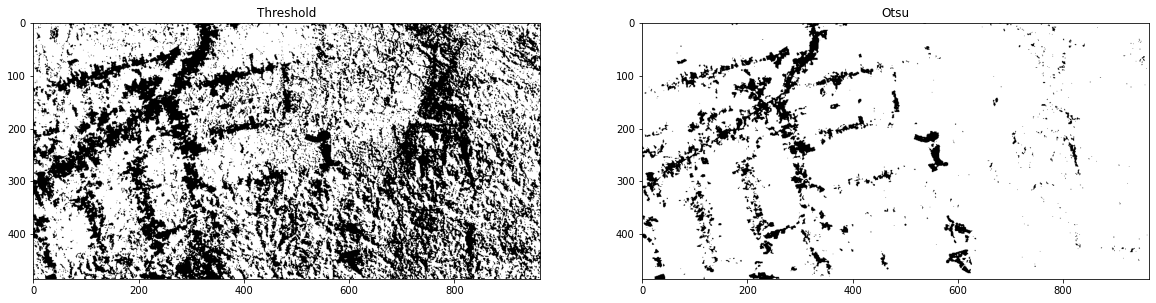

In [64]:
img_gray = luminance(blur_img)  # imagem em escala de cinza
mean = np.mean(img_gray)        # intensidade média da imagem

threshold_img = thresholding(img_gray, mean)  # aplicação da segmentação por threshold fixo
otsu_img = otsu_threshold(img_gray)           # aplicação da segmentação por threshold dinâmico (método de Otsu)

imgs = {'Threshold': threshold_img, 'Otsu': otsu_img}
display_comparison(imgs, ['Threshold', 'Otsu'])

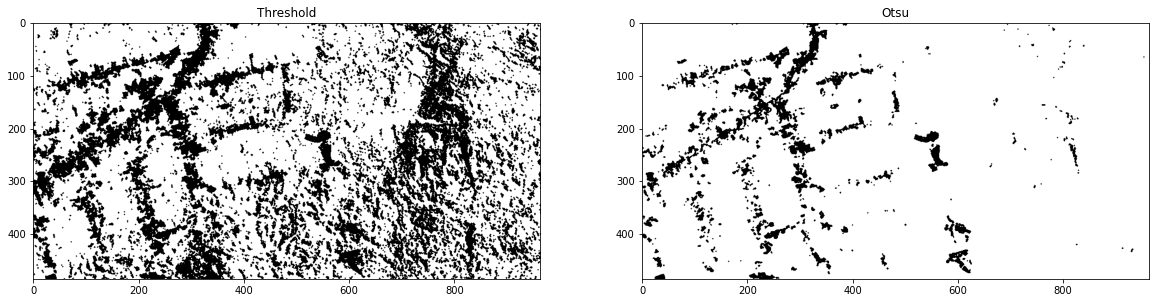

In [65]:
dilated_img1 = cv2.dilate(threshold_img, disk1)
eroded_img1 = cv2.erode(dilated_img1, disk1)
threshold_img = eroded_img1

dilated_img1 = cv2.dilate(otsu_img, disk1)
eroded_img1 = cv2.erode(dilated_img1, disk1)
otsu_img = eroded_img1

imgs = {'Threshold': threshold_img, 'Otsu': otsu_img}
display_comparison(imgs, ['Threshold', 'Otsu'])

### Remoção de áreas pequenas

Aqui, a ideia é remover áreas que sejam pequenas para remover possíveis ruídos

In [66]:
metro2_por_pixel = 10   # escala da imagem

In [67]:
def remove_small_areas(img, percentage):
  # atribui índices para regiões segmentadas da imagem
  img_floodfill, labels = label(img, return_num=True)
  # determina área máxima para remoção 
  threshold = min(2000, (img_floodfill.shape[0] * percentage) * (img_floodfill.shape[1] * percentage))

  for i in range(1, labels):
      if np.sum(img_floodfill == i) < threshold:
          img_floodfill[img_floodfill == i] = 0

  img_floodfill[img_floodfill != 0] = 255
  return img_floodfill

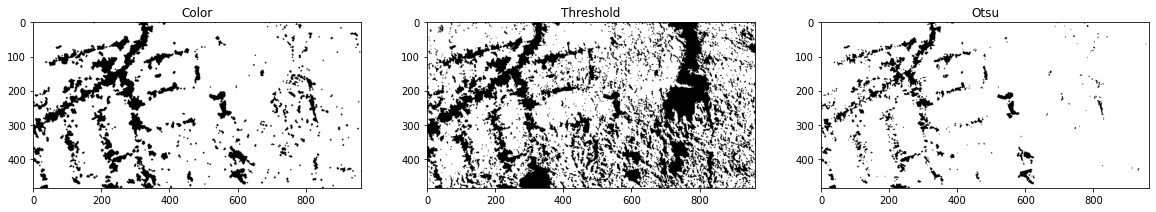

In [68]:
img_floodfill_color = remove_small_areas(disk2_img, 0.05)
img_floodfill_threshold = remove_small_areas(threshold_img, 0.05)
img_floodfill_otsu = remove_small_areas(otsu_img, 0.05)

imgs = {'Color': img_floodfill_color, 'Threshold': img_floodfill_threshold, 'Otsu': img_floodfill_otsu}
display_comparison(imgs, ['Color', 'Threshold', 'Otsu'])

### Destaca regiões baseado nas bordas

Utilizando um filtro laplaciano

In [69]:
def edge(img):
    laplacian_filter = np.array([
    [1,  1, 1],
    [1, -8, 1],
    [1,  1, 1]
    ], np.int8)

    edge = np.zeros(img.shape)
    padded = np.pad(img, 1, 'edge')

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            edge[i, j] = np.sum(padded[i : i + 3, j : j + 3] * laplacian_filter)

    edge = np.clip(edge, 0, 1) * 255
    return edge

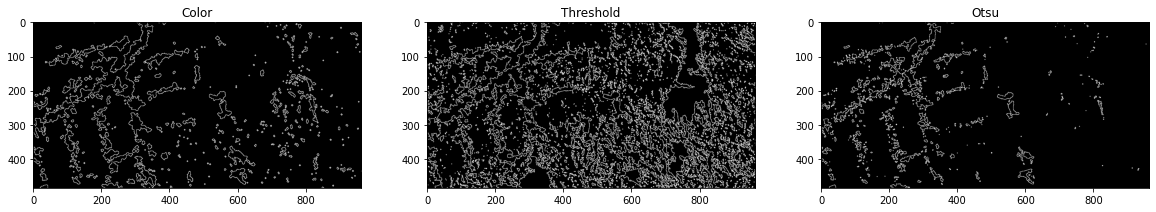

In [70]:
img_edge_color = edge(img_floodfill_color) 
img_edge_threshold = edge(img_floodfill_threshold)
img_edge_otsu = edge(img_floodfill_otsu)

imgs = {'Color': img_edge_color, 'Threshold': img_edge_threshold, 'Otsu': img_edge_otsu}
display_comparison(imgs, ['Color', 'Threshold', 'Otsu'])

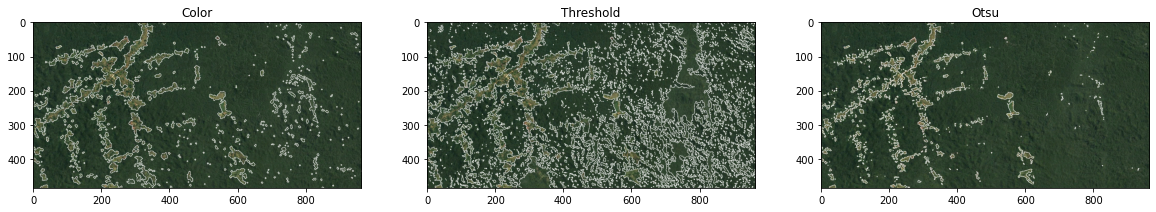

True

In [71]:
img_final_color = img.copy()
img_final_threshold = img.copy()
img_final_otsu = img.copy()

img_final_color[img_edge_color == 255, :] = 255
img_final_threshold[img_edge_threshold == 255, :] = 255
img_final_otsu[img_edge_otsu == 255, :] = 255

imgs = {'Color': img_final_color, 'Threshold': img_final_threshold, 'Otsu': img_final_otsu}
display_comparison(imgs, ['Color', 'Threshold', 'Otsu'])

cv2.imwrite('final_color_' + img_path, cv2.cvtColor(img_final_color, cv2.COLOR_BGR2RGB))
cv2.imwrite('final_threshold_' + img_path, cv2.cvtColor(img_final_threshold, cv2.COLOR_BGR2RGB))
cv2.imwrite('final_otsu_' + img_path, cv2.cvtColor(img_final_otsu, cv2.COLOR_BGR2RGB))

In [72]:
print('\033[1mÁrea de floresta (Color):\033[0m', np.sum(img_floodfill_color) / 255 * metro2_por_pixel / 10000, 'hectares')
print('\033[1mÁrea de floresta (Threshold):\033[0m', np.sum(img_floodfill_threshold) / 255 * metro2_por_pixel / 10000, 'hectares')
print('\033[1mÁrea de floresta (Otsu):\033[0m', np.sum(img_floodfill_otsu) / 255 * metro2_por_pixel / 10000, 'hectares')

Área de floresta (Color): 408.531 hectares
Área de floresta (Threshold): 312.404 hectares
Área de floresta (Otsu): 438.516 hectares
